#Importing Libraries and Data

In [21]:
import pandas as pd
from google.colab import drive
import statistics
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind

sns.set(style="darkgrid")

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Upload the file onto google colab
kindle_data = pd.read_csv('kindle_data-v2.csv')

In [ ]:
# Preview the data
kindle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133102 entries, 0 to 133101
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               133102 non-null  object 
 1   title              133102 non-null  object 
 2   author             132677 non-null  object 
 3   soldBy             123869 non-null  object 
 4   imgUrl             133102 non-null  object 
 5   productURL         133102 non-null  object 
 6   stars              133102 non-null  float64
 7   reviews            133102 non-null  int64  
 8   price              133102 non-null  float64
 9   isKindleUnlimited  133102 non-null  bool   
 10  category_id        133102 non-null  int64  
 11  isBestSeller       133102 non-null  bool   
 12  isEditorsPick      133102 non-null  bool   
 13  isGoodReadsChoice  133102 non-null  bool   
 14  publishedDate      84086 non-null   object 
 15  category_name      133102 non-null  object 
dtypes:

In [ ]:
# Basic statistics of the dataset
kindle_data.describe()

,stars,reviews,price,category_id
count,133102.000000,133102.000000,133102.000000,133102.000000
mean,4.404090,887.375779,15.134127,16.287111
std,0.745646,5104.878777,22.254986,8.416924
min,0.000000,0.000000,0.000000,1.000000
25%,4.400000,0.000000,4.990000,9.000000
50%,4.500000,4.000000,9.990000,16.000000
75%,4.700000,365.000000,14.990000,23.000000
max,5.000000,618227.000000,682.000000,31.000000


# Cleaning the Data

In [6]:
# Count how many duplicates there are of books:
duplicate_count = kindle_data.duplicated(subset=['asin']).sum()
print("Number of duplicates:", duplicate_count) #0
duplicate_count = kindle_data.duplicated(subset=['title','author']).sum()
print("Number of duplicates:", duplicate_count) #847
# There are no asin duplicates but there are duplicates of books.
# Display duplicate rows
duplicate_rows = kindle_data[kindle_data.duplicated(subset=['title','author'], keep=False)]
# Sort duplicates by the 'title' column alphabetically so it's easier to see the duplicates
sorted_duplicates = duplicate_rows.sort_values(by='title')
# print("Duplicate Rows:")
# print(duplicate_rows.head(50))
# This can be becuase once a book is published on Amazon,
# the only way to republish a revised edition of the book is by using a new asin.
# We'll drop duplicates and keep the most recentally published version.
kindle_data['published_date'] = pd.to_datetime(kindle_data['publishedDate'])
kindle_data.sort_values(by='published_date', ascending=False, inplace=True)
# Keep only the rows with the most recent published date for each title
kindle_data_clean = kindle_data.drop_duplicates(subset='title', keep='first')
# Check that there are no duplicates
duplicate_count = kindle_data_clean.duplicated(subset=['title','author']).sum()
print("Number of duplicates:", duplicate_count)

Number of duplicates: 0
Number of duplicates: 847
Number of duplicates: 0


In [7]:
# We do not need the foreign data books for our charts. We will only focus on the English books
kindle_data=kindle_data[kindle_data['category_name']!='Foreign Language']
# Check that the foreign language books are cleared
kindle_data[kindle_data['category_name']=='Foreign Language']

,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,published_date


In [8]:
# Check how many rows have many missing values
kindle_data_clean.shape # There are 17 columns total, we'll check how many are missing 5
na_count_threshold = 5
rows_with_many_na = kindle_data_clean.isnull().sum(axis=1) > na_count_threshold
rows_count = rows_with_many_na.sum()
print("Number of rows with more than", na_count_threshold, "NaN values:", rows_count) #0

Number of rows with more than 5 NaN values: 0


In [9]:
# Check which columns contain nulls
null_counts = kindle_data_clean.isnull().sum()
# Print the null counts for each column
print("Null Value Counts for Each Column:")
print(null_counts)
# Looks like all nulls are in author, soldby, and publisheddate columns which are not used in our charts.

Null Value Counts for Each Column:
asin                     0
title                    0
author                 421
soldBy                9017
imgUrl                   0
productURL               0
stars                    0
reviews                  0
price                    0
isKindleUnlimited        0
category_id              0
isBestSeller             0
isEditorsPick            0
isGoodReadsChoice        0
publishedDate        48746
category_name            0
published_date       48746
dtype: int64


In [10]:
# We looked through the dataset and noticed that the main inaccuracy with the categories was romance.
# There were some books that had romance in the title but were in different catagories.
# Here we. switch them to romance.
new=kindle_data_clean[kindle_data_clean['title'].str.contains(r'(romantic|romcom|romance)',case=False,na=False)]
kindle_data_clean.loc[new.index,'category_name']='Romance'
kindle_data_clean.loc[new.index,'category_id']=7
# Change the category ID too.
kindle_data[kindle_data['title'].str.contains(r'(romantic|romcom|romance)',case=False,na=False)].head()

<ipython-input-10-85291142137f>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new=kindle_data_clean[kindle_data_clean['title'].str.contains(r'(romantic|romcom|romance)',case=False,na=False)]
<ipython-input-10-85291142137f>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  kindle_data[kindle_data['title'].str.contains(r'(romantic|romcom|romance)',case=False,na=False)].head()


,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,published_date
69985,B0CH14JLT6,Be My Endgame: An MM Rivals-to-Lovers Sports R...,Zarah Detand,Amazon.com Services LLC,https://m.media-amazon.com/images/I/7140fc6Yal...,https://www.amazon.com/dp/B0CH14JLT6,4.7,23,5.19,True,28,False,False,False,2023-09-29,LGBTQ+ eBooks,2023-09-29
21045,B0CJ8VX5SX,The Don's Enemy Within: A Secret Baby Mafia Ro...,Amber Row,Amazon.com Services LLC,https://m.media-amazon.com/images/I/71IaobTbNj...,https://www.amazon.com/dp/B0CJ8VX5SX,4.5,0,0.99,True,21,False,False,False,2023-09-28,"Mystery, Thriller & Suspense",2023-09-28
29315,B0CJQRWM86,Gentry Rules (Friends to Lovers Small Town Rom...,Cora Brent,Amazon.com Services LLC,https://m.media-amazon.com/images/I/91gqYZE8fg...,https://www.amazon.com/dp/B0CJQRWM86,4.9,35,3.99,True,5,False,False,False,2023-09-28,Literature & Fiction,2023-09-28
24216,B0CK3QH8WZ,Cypress Cove: A Little Adventure. A Little Rom...,Elizabeth Parker,Amazon.com Services LLC,https://m.media-amazon.com/images/I/61OCpWKRE2...,https://www.amazon.com/dp/B0CK3QH8WZ,5.0,0,7.99,True,26,False,False,False,2023-09-27,"Crafts, Hobbies & Home",2023-09-27
103645,B0C7CZKHK1,Christmas in Coolsbay: A cosy friends-to-lover...,Belle Henderson,Amazon.com Services LLC,https://m.media-amazon.com/images/I/71-c24oJf8...,https://www.amazon.com/dp/B0C7CZKHK1,5.0,0,0.99,True,12,False,False,False,2023-09-27,Humor & Entertainment,2023-09-27


In [11]:
# We want to create price bins for the different price catagories.
# We'll start with the books under $5.
# Majority of the books are inexpensive, around 100k are under $20.
kindle_data_clean[(kindle_data_clean['price']>1)&(kindle_data_clean['price']<5)].count()
kindle_data_clean[(kindle_data_clean['price']>1)&(kindle_data_clean['price']<10)].count()

asin                 70819
title                70819
author               70499
soldBy               65814
imgUrl               70819
productURL           70819
stars                70819
reviews              70819
price                70819
isKindleUnlimited    70819
category_id          70819
isBestSeller         70819
isEditorsPick        70819
isGoodReadsChoice    70819
publishedDate        34515
category_name        70819
published_date       34515
dtype: int64

In [12]:
Under_5= kindle_data_clean[(kindle_data_clean['price']>0)&(kindle_data_clean['price']<=5)]
kindle_data_clean.loc[Under_5.index,'PriceUnder_5']= 1
kindle_data_clean['PriceUnder_5']=kindle_data_clean.PriceUnder_5.fillna(0).astype(int)

In [13]:
Under_10= kindle_data_clean[(kindle_data_clean['price']>0)&(kindle_data_clean['price']<=10)]
kindle_data_clean.loc[Under_10.index,'PriceUnder_10']= 1
kindle_data_clean['PriceUnder_10']=kindle_data_clean.PriceUnder_10.fillna(0).astype(int)

In [14]:
Under_20= kindle_data_clean[(kindle_data_clean['price']>0)&(kindle_data_clean['price']<=20)]
kindle_data_clean.loc[Under_20.index,'PriceUnder_20']= 1
kindle_data_clean['PriceUnder_20']=kindle_data_clean.PriceUnder_20.fillna(0).astype(int)

In [15]:
Over_20= kindle_data_clean[(kindle_data_clean['price']>20)]
kindle_data_clean.loc[Over_20.index,'PriceOver_20']= 1
kindle_data_clean['PriceOver_20']=kindle_data_clean.PriceOver_20.fillna(0).astype(int)

In [16]:
# For the charts we should prob keep these as boolians
kindle_data_clean['isBestSellerint']=kindle_data_clean['isBestSeller'].astype(int)
kindle_data_clean['isGoodReadsChoiceint']=kindle_data_clean['isGoodReadsChoice'].astype(int)
kindle_data_clean['isEditorsPickint']=kindle_data_clean['isEditorsPick'].astype(int)

# Anaylsis of the Data

In [17]:
# Drop rows with missing values if needed
numerical_columns = kindle_data_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Split the data into features (X) and target (y) using only numerical columns
X = kindle_data_clean[numerical_columns].drop('isBestSellerint', axis=1)
y = kindle_data_clean['isBestSellerint']

# F test

for col in X.columns:
    if X[col].dtype == 'int64' or X[col].dtype == 'float64':
        # Perform F-test for multiple groups
        f_statistic, p_value = f_oneway(X[col][y == 0], X[col][y == 1])
        print(f"F-test p-value for {col}: {p_value}")
    else:
        # Perform t-test for two groups
        t_statistic, p_value = ttest_ind(X[col][y == 0], X[col][y == 1])
        print(f"t-test p-value for {col}: {p_value}")

F-test p-value for stars: 5.664797474243214e-08
F-test p-value for reviews: 4.937221093952315e-15
F-test p-value for price: 1.0136309319922893e-56
F-test p-value for category_id: 0.20373494683015667
F-test p-value for PriceUnder_5: 1.7219280061619951e-125
F-test p-value for PriceUnder_10: 2.1986389972724065e-70
F-test p-value for PriceUnder_20: 2.484114949462734e-42
F-test p-value for PriceOver_20: 6.23421899390437e-56
F-test p-value for isGoodReadsChoiceint: 1.4288896905618622e-06
F-test p-value for isEditorsPickint: 5.079219186544369e-23


In [18]:
# T test
from scipy.stats import ttest_ind

# Assuming 'X' is your feature matrix with numerical variables
for col in X.columns:
    if X[col].dtype == 'int64' or X[col].dtype == 'float64':
        # Perform t-test for two groups (0 and 1 in the target variable y)
        t_statistic, p_value = ttest_ind(X[col][y == 0], X[col][y == 1])
        print(f"t-test p-value for {col}: {p_value}")

t-test p-value for stars: 5.664797474549049e-08
t-test p-value for reviews: 4.937221094159512e-15
t-test p-value for price: 1.0136309320406328e-56
t-test p-value for category_id: 0.20373494684270996
t-test p-value for PriceUnder_5: 1.7219280062335072e-125
t-test p-value for PriceUnder_10: 2.1986389973687785e-70
t-test p-value for PriceUnder_20: 2.4841149495933245e-42
t-test p-value for PriceOver_20: 6.2342189942096145e-56
t-test p-value for isGoodReadsChoiceint: 1.4288896906376177e-06
t-test p-value for isEditorsPickint: 5.0792191867810155e-23


In [19]:
# Welchs T test
from scipy.stats import ttest_ind

for col in X.columns:
    if X[col].dtype == 'int64' or X[col].dtype == 'float64':
        # Perform Welch's t-test for two groups (0 and 1 in the target variable y)
        t_statistic, p_value = ttest_ind(X[col][y == 0], X[col][y == 1], equal_var=False)
        print(f"Welch's t-test p-value for {col}: {p_value}")


Welch's t-test p-value for stars: 2.90206742804541e-26
Welch's t-test p-value for reviews: 5.4893262276400514e-08
Welch's t-test p-value for price: 0.0
Welch's t-test p-value for category_id: 0.2108987444007041
Welch's t-test p-value for PriceUnder_5: 1.4227306143867734e-83
Welch's t-test p-value for PriceUnder_10: 4.332924453700546e-82
Welch's t-test p-value for PriceUnder_20: 4.2415353927170396e-88
Welch's t-test p-value for PriceOver_20: 1.1670366885937743e-198
Welch's t-test p-value for isGoodReadsChoiceint: 6.296929310057719e-300
Welch's t-test p-value for isEditorsPickint: 0.0


Accuracy: 0.9825651910248635
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6481
           1       0.00      0.00      0.00       115

    accuracy                           0.98      6596
   macro avg       0.49      0.50      0.50      6596
weighted avg       0.97      0.98      0.97      6596

Confusion Matrix:
[[6481    0]
 [ 115    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


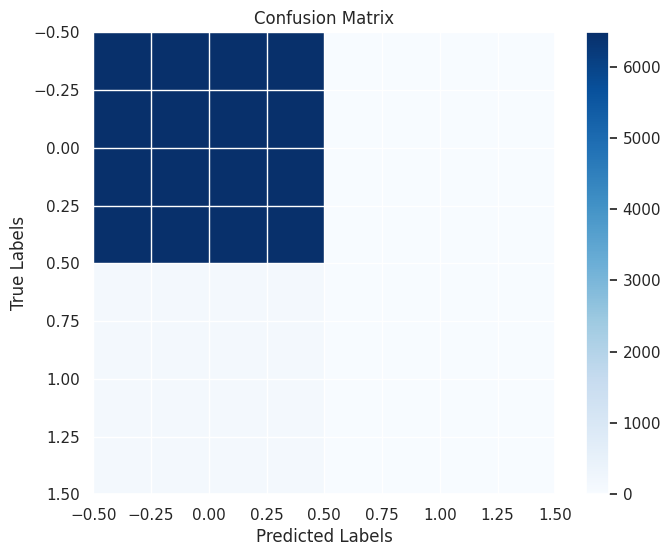

In [20]:
# Logistic Regression:
# Drop rows with missing values if needed
numerical_columns = kindle_data_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Split the data into features (X) and target (y) using only numerical columns
X = kindle_data_clean[numerical_columns].drop('isBestSellerint', axis=1)
y = kindle_data_clean['isBestSellerint']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[6237  244]
 [ 101   14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6481
           1       0.05      0.12      0.08       115

    accuracy                           0.95      6596
   macro avg       0.52      0.54      0.52      6596
weighted avg       0.97      0.95      0.96      6596



In [ ]:
# Preview of the data
kindle_data.head()

,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,...,publishedDate,category_name,published_date,PriceUnder_5,PriceUnder_10,PriceUnder_20,PriceOver_20,isBestSellerint,isGoodReadsChoiceint,isEditorsPickint
128116,B0C6SN8WRB,Nightshade Revenge (Alex Rider Book 14),Anthony Horowitz,NaN,https://m.media-amazon.com/images/I/91Cqo4k80j...,https://www.amazon.com/dp/B0C6SN8WRB,4.4,0,10.99,False,...,2024-01-16,Children's eBooks,2024-01-16,0,0,1,0,0,0,0
131844,1338875663,Baby-Sitters' Winter Vacation (The Baby-Sitter...,NaN,NaN,https://m.media-amazon.com/images/I/71wYZm1Awi...,https://www.amazon.com/dp/1338875663,4.5,0,8.99,False,...,2023-12-05,Children's eBooks,2023-12-05,0,1,1,0,0,0,0
129632,0063309009,The Bridge Battle,Jacqueline Davies,NaN,https://m.media-amazon.com/images/I/81WQ1O48c+...,https://www.amazon.com/dp/0063309009,0.0,0,9.99,False,...,2023-11-14,Children's eBooks,2023-11-14,0,1,1,0,0,0,1
129673,0063143968,Warriors: The Ultimate Guide: Updated and Expa...,Erin Hunter,NaN,https://m.media-amazon.com/images/I/81zEicMMxE...,https://www.amazon.com/dp/0063143968,4.8,0,21.99,False,...,2023-10-31,Children's eBooks,2023-10-31,0,0,0,1,0,0,0
103703,B0CFGJY162,Company of Foos,Paul Davidson,Amazon.com Services LLC,https://m.media-amazon.com/images/I/81HidjdXPN...,https://www.amazon.com/dp/B0CFGJY162,0.0,0,9.49,False,...,2023-10-17,Humor & Entertainment,2023-10-17,0,1,1,0,0,0,0


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Undersample the books that are 0 for best seller
undersampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model's accuracy and other metrics
accuracy = logreg.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.632420091324201


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Export the dataset as a csv to google drive
kindle_data_clean.to_csv('/content/drive/My Drive/kindleclean.csv', index=False)